In [1]:
import numpy as np
import serial
import adi   #Make sure libiio and py-adi and their dependencies are all installed. 
import time
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import re
import csv

In [2]:
ser = serial.Serial('/dev/ttyUSB0')



sdr = adi.FMComms5(uri='ip:analog.local')  #This has to match the address of the Zynq board
freq = 3000000000
sdr.rx_lo = freq  #Change as desired 
sdr.rx_lo_chip_b = freq
samplerate = 60000000
sdr.sample_rate = samplerate
bandwidth = 18000000
sdr.rx_rf_bandwidth = bandwidth
sdr.rx

angleLimit = 45

In [3]:
pattern_theta_list = []
pattern_list = []

In [4]:
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False


def Get_Combined_RX_Pwr(data):

    dataC = data[0] + data[1] + data[2] + data[3]

    NUM_SAMPLES = 1024

    max_pwr_search_size = 30
    # f = np.linspace(-0.5 * samplerate, 0.5 * samplerate, len(dataC))
    f_carrier = np.linspace(-0.5 * samplerate, 0.5 * samplerate, NUM_SAMPLES) + (freq)

    data_fft = (20 * np.log10(np.abs(np.fft.fftshift(np.fft.fft(dataC))) / NUM_SAMPLES)) - 20
    carrier_data = [np.transpose(f_carrier), data_fft]
    carrier_data = np.asanyarray(carrier_data)

    # indexes = indices(carrier_data[0], lambda x: x > freq - 1e6 and x < freq + 1e6)
    indexes = np.linspace(NUM_SAMPLES/2 - max_pwr_search_size, NUM_SAMPLES/2 + max_pwr_search_size, dtype=int)

    pwr=max(data_fft[indexes])
    
    return pwr


def CWReceive():
    
    data = "CR\n"
    ser.write(data.encode('ascii'))
    data = "CW\n"
    ser.write(data.encode('ascii'))

    pos = ""
    while(True):
        data = "CP?\n"
        ser.write(data.encode('ascii'))
        line = ser.readline()
        l = line.decode('utf-8').rstrip()
        if l:
            if l != "\x06":
                if is_float(l):
                    pos = float(l)
                    x = sdr.rx()
                    rx = np.asarray(x)
                    pwr_db = Get_Combined_RX_Pwr(rx)

                    pattern_theta_list.append(pos)
                    pattern_list.append(pwr_db)

                    print("{} deg = {} dB".format(pos, pwr_db))


                    if(np.abs(float(l) - angleLimit) < 0.2):
                        break
    while(True):
        data = "ST\n"
        ser.write(data.encode('ascii'))
        data = "DIR?\n"
        ser.write(data.encode('ascii'))
        line = ser.readline()
        l = line.decode('utf-8').rstrip()

        if l:
            if l != "\x06":
                if l == 'N':
                    break

    data = "ST\n"
    ser.write(data.encode('ascii'))

def CCReceive():
    
    cc_angle_limit = 360.0 - angleLimit
    data = "CR\n"
    ser.write(data.encode('ascii'))
    data = "CC\n"
    ser.write(data.encode('ascii'))

    pos = ""
    while(True):
        data = "CP?\n"
        ser.write(data.encode('ascii'))
        line = ser.readline()
        l = line.decode('utf-8').rstrip()
        if l:
            if l != "\x06":
                if is_float(l):
                    pos = float(l)
                    x = sdr.rx()
                    rx = np.asarray(x)
                    pwr_db = Get_Combined_RX_Pwr(rx)

                    pattern_theta_list.append(pos)
                    pattern_list.append(pwr_db)
                    print("{} deg = {} dB".format(pos, pwr_db))

                    if(np.abs(float(l) - cc_angle_limit) < 0.2):
                        break
    while(True):
        data = "ST\n"
        ser.write(data.encode('ascii'))
        data = "DIR?\n"
        ser.write(data.encode('ascii'))
        line = ser.readline()
        l = line.decode('utf-8').rstrip()

        if l:
            if l != "\x06":
                if l == 'N':
                    break

    data = "ST\n"
    ser.write(data.encode('ascii'))


In [5]:
CCReceive()
CWReceive()

60.2 deg = 14.8815312571801 dB
60.2 deg = 14.556170354283942 dB
60.2 deg = 14.427156613080747 dB
60.2 deg = 13.584399460188607 dB
60.1 deg = 14.07158737764567 dB
60.1 deg = 13.590395462515986 dB
60.0 deg = 13.301960864702295 dB
59.9 deg = 14.060801517880911 dB
59.8 deg = 14.719349488639125 dB
59.8 deg = 13.295493768835982 dB
59.7 deg = 12.880729058712376 dB
59.6 deg = 13.395286836987559 dB
59.5 deg = 13.302679434856671 dB
59.4 deg = 13.15803133846024 dB
59.3 deg = 13.468064584454162 dB
59.2 deg = 14.330242250412738 dB
59.1 deg = 13.69698018411961 dB
59.0 deg = 12.5890169847668 dB
58.9 deg = 13.56755911361671 dB
58.8 deg = 13.608198760302287 dB
58.7 deg = 13.952436197898173 dB
58.6 deg = 15.447990198211642 dB
58.5 deg = 15.021244580754434 dB
58.5 deg = 13.924017577415057 dB
58.4 deg = 14.890162156417716 dB
58.3 deg = 14.967309277957732 dB
58.2 deg = 13.771052450232169 dB
58.1 deg = 15.077228704715708 dB
58.0 deg = 15.169542216861444 dB
57.9 deg = 15.00875954235503 dB
57.8 deg = 15.41247

-1.6334852306578398


/home/jta/GPSJamming/gpsvenv/lib/python3.10/site-packages/matplotlib/ticker.py:2918: RuntimeWarning: invalid value encountered in log10
  majorstep_no_exponent = 10 ** (np.log10(majorstep) % 1)


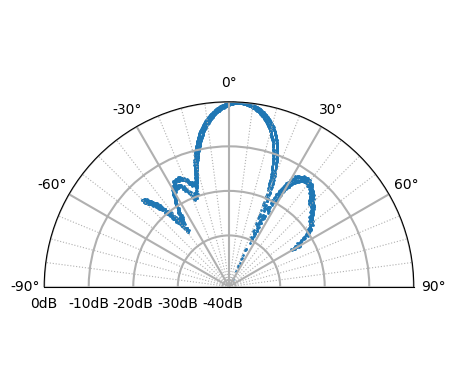

In [60]:
pattern_theta = np.asarray(pattern_theta_list)
pattern_theta = np.deg2rad(pattern_theta)
pattern = np.asarray(pattern_list)
sorted_theta_ind = np.argsort(pattern_theta)


pattern_theta = pattern_theta[sorted_theta_ind]
pattern = pattern[sorted_theta_ind] * 1




max_pwr = np.max(pattern)
min_pwr = np.min(pattern)

print(min_pwr)


pattern = pattern - max_pwr

# fig, ax = plt.subplots(subplot_kw={"projection" : "polar"})
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.set_theta_direction('clockwise')


# ax.plot(pattern_theta,pattern,linewidth= 2.5)
ax.scatter(pattern_theta, pattern, s=1)
# ax.set_thetamin(0)
ax.set_thetalim(-np.pi / 2, np.pi/2)
ax.set_thetagrids([-90, -60, -30, 0,30, 60,90])
ax.set_rticks([0, -10,-20, -30, -40],labels= ["0dB", "-10dB","-20dB","-30dB","-40dB"])
ax.set_theta_zero_location("N")
# ax.set_rlabel_position(135)

ax.grid(True,which="minor",linestyle= ":")
ax.grid(True,which="major",linewidth= 1.5)
ax.minorticks_on()
plt.show()